# Simulating a Storm Cloud in 3D

*Written by Tor Ole Odden and Karl Henrik Fredly.*

## Introduction

This notebook simulates a storm cloud, modeling it as a parallel-plate capacitor. It is based in large part on information from a report called "The Physics of Lightning" by [Dwyer and Uman](http://doi.org/10.1016/j.physrep.2013.09.004). You can also find a short description of the basic concepts at [hyperphysics](http://hyperphysics.phy-astr.gsu.edu/hbase/electric/lightning.html#c1). 

This code calculates the electric field a certain distance away from the cloud, at a specified observation position. There are some suggestions for investigation questions and the end, but you are welcome to play around with the parameters in the code, add or subtract different pieces, and see how it behaves for yourself as you decide what you want to use it to investigate.

## Simulation of the Storm Cloud 

First, we import our various libraries: numpy for efficient calculations, and matplotlib for plotting.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

Now, we will define some constants: the dimensions of the cloud, altitude of the cloud, charge of the positive and negative part of the cloud, and the observation position (where we are observing the electric field from the cloud).

In [2]:
startx = -2500 #Define where the parts of the clouds should start/stop in the x direction
endx = 2500

startz = -2500 #Define where the cloud should start/stop in the z direction
endz = 2500

negheight = 6000 #set the negative cloud at a height (in the y direction) of 6000m
posheight = 8000 #set the positive cloud at a height of 8000m

Q = -15 #Q is the total charge on the bottom (negative) part of the cloud
Q2 = 15 #Q2 is the total charge of the top (positive) part of the cloud

k = 9e9 #Coulomb's constant

obspos = np.array([0,0,0]) #the observation position (start at 0,0,0)

Now, we will define the chunks we break the clouds (and net charge) into. First, we'll define how many "chunks" we'll break the cloud into in the x and z direction, the size of each of those chunks (based on the overall size of the cloud) and the charge of each of those chunks. chunkx holds the possible

In [3]:
nx = 100 #Define how many chunks to split the cloud in the x direction (define x size of the cloud grid)
nz = 100 #Define how many chunks to split the cloud in the z direction (define z size of the cloud grid)

chunkx = np.linspace(startx, endx, nx) #Holds the x positions of the chunks
chunkz = np.linspace(startz, endz, nz) #Holds the z positions of the chunks

dQ = Q/(nx*nz) #Charge of each chunk of the the negative part of the cloud
dQ2 = Q2/(nx*nz) #Charge of each chunk of the positive part of the cloud

Now we will define a function that returns the E-field from the negative and positive chunks with the x-position xpos and z-position zpos at the location obspos. Later we will use this function on every chunk to find the total E-field.

(Note that "np.linalg.norm" essentially takes the magnitude of a vector or array, so we use that in calculating the e-field)

In [4]:
def efield(xpos, zpos, obspos):
    """Calculates the e-field due to a +/- chunk of the cloud at a specified x and z position"""
    negChunk = np.array([xpos, negheight, zpos]) #Position of negative cloud chunk
    posChunk = np.array([xpos, posheight, zpos]) #Position of positive cloud chunk
    
    negfield = k * dQ / (np.linalg.norm(obspos-negChunk))**2 #Formula for E-field at obspos from charged particle
    posfield = k * dQ2/ (np.linalg.norm(obspos-posChunk))**2 #        at the chunk position with charge dQ

    return negfield + posfield #The E-field from the pair of chunks with the same x and z position

We now have a function that takes in three vectors and returns a scalar. We want to evaluate this function on every cloud chunk x- and z-position, which will be a nx\*nz grid of points. We could use two for-loops to iterate over the possible x- and z-positions of the chunks, but it is more efficient to vectorize the operation. More specifically, we will use two clever vectorization tricks built into numpy.

First, we turn the arrays chunkx and chunkz into 2-D vectors, using the built-in option of "None" in numpy array definitions (which is equivalent to np.newaxis). This essentially allows you to add another "blank" dimension to an array. Here, we use it to turn our chunkx and chunkz arrays from 1D to 2D, which in turn allows us to use numpy's matrix manipulation functions (more info on this [here](https://medium.com/@ian.dzindo01/what-is-numpy-newaxis-and-when-to-use-it-8cb61c7ed6ae)).

Second, we pass these 2D numpy arrays to our previously-defined e-field function. Through the magic of python, our function understands that we want it to iterate over the values in each of these arrays and perform the desired calculation on each possible combination of values. This yields an array of size 100 x 100, holding the e-field contributions from all cloud chunks at each point in the grid.

Finally, we sum all of these values together to get our final e-field.

In [5]:
#Vectorized command to find the e-field due to all chunks of the cloud
totField = np.sum(efield(chunkx[:,None], chunkz[None,:], obspos))

print("The e-field at the observation position is {:.3f} Newtons per coulomb".format(totField))

The e-field at the observation position is -1387.612 Newtons per coulomb


With 100 by 100 chunks, we get an e-field of -1387.612 N/C at (0, 0, 0).

Based on some quick tests, this is about 0.27% different from the value with 1000 by 1000 chunks, so it seems that we don't lose too much precision by using 100x100 chunks, and it goes significantly faster when plotting.

## Plotting the E-field

By calculating the E-field at a grid of points in the xy-plane we can plot the E-field. This will require us to not only specify the number of chunks in the cloud, but also a set of points where we will plot the e-field.

In [6]:
dim = 100 #Number of points to plot in each direction

xvals = np.linspace(-3000, 3000, dim) #The x-positions where we will calculate the E-field
yvals = np.linspace(0, 9000, dim) #The y-positions where we will calculate the E-field

egrid = np.empty((dim, dim)) #An array holding the E-field at every position on the grid

Now, we iterate over the specified positions and use our previously defined function (plus the magic of vectorized python code) to calculate the e-field at that location.

In [7]:
for i in range(len(xvals)):
    xpos = xvals[i]
    for j in range(len(yvals)):
        ypos = yvals[j]
        obspos = np.array([xpos, ypos, 0])
        
        #This calculates and stores the E-field at a grid of points in the xy-plane
        egrid[j][i] = np.sum(efield(chunkx[:,None], chunkz[None,:], obspos))

To plot this, we create a mesh grid out of the x and y values, and plot the e-field values over that grid of coordinates.

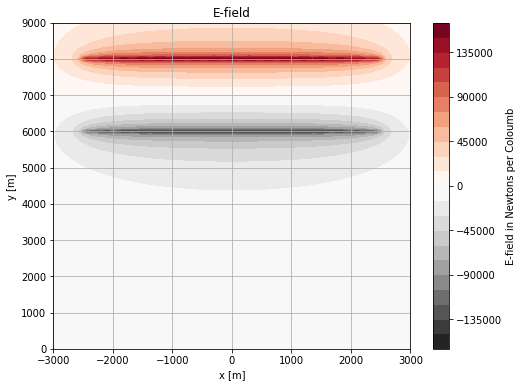

In [8]:
X, Y = np.meshgrid(xvals, yvals)

plt.figure(figsize=(8, 6))
ax = plt.contourf(X, Y, egrid, 25, cmap='RdGy_r')
cbar = plt.colorbar()
cbar.ax.set_ylabel('E-field in Newtons per Coloumb')

plt.grid()
plt.title("E-field")
plt.xlabel("x [m]")
plt.ylabel("y [m]")
plt.show()

### Plotting the E-field close to the ground

By changing the area to plot to be closer to the ground we can get a better idea of how the E-field looks there.

In [9]:
dim2 = 100 #Number of values to plot
xvals2 = np.linspace(-3000, 3000, dim2) #The x positions where we will calculate the e-field
yvals2 = np.linspace(0, 1000, dim2) #The y positions where we will calculate the e-field

egrid2 = np.empty((dim2, dim2)) #An array holding the E-field at every position on the grid
egrid2[:] = np.nan

In [10]:
for i in range(len(xvals2)):
    xpos = xvals2[i]
    for j in range(len(yvals2)):
        ypos = yvals2[j]
        obspos = np.array([xpos, ypos, 0])
        egrid2[j][i] = np.sum(efield(chunkx[:,None], chunkz[None,:], obspos))

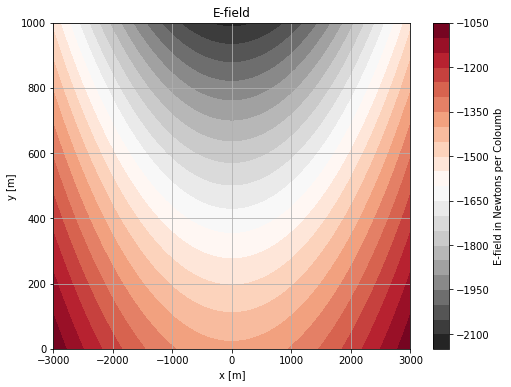

In [11]:
X2, Y2 = np.meshgrid(xvals2, yvals2)

plt.figure(figsize=(8, 6))
ax = plt.contourf(X2, Y2, egrid2, 25, cmap='RdGy_r')
cbar = plt.colorbar()
cbar.ax.set_ylabel('E-field in Newtons per Coloumb')

plt.grid()
plt.title("E-field")
plt.xlabel("x [m]")
plt.ylabel("y [m]")
plt.show()

## Additional questions you might investigate 

1. How likely is it for lightning to strike a particular spot, knowing that the electric field breakdown of air is about 3e6 V/M? How far away from the cloud would you have to be to be safe from lightning?
    * What if the cloud polarizes the ground, or an object near the ground?
2. Actual clouds have a certain thickness. How does this calculation change if the clouds are not thin sheets, but are 3D instead?
3. It turns out that in reality, there are multiple layers of + and - charge, each with somewhat different charge densities (see *Marshall, T. C., & Stolzenburg, M. (1998). Estimates of cloud charge densities in thunderstorms. Journal of Geophysical Research, 103(D16), 19769–19775.*) What happens if there are extra layers of positive or negative charge in these clouds?
4. What if the cloud is larger or smaller? Higher up or closer to the ground?

*(Note that these are just meant to be suggestions—feel free to investigate any question you find interesting!)*

For more information on clouds and lightning (including approximate numbers for many of the physical characteristics of storm clouds) see *Dwyer, J. R., & Uman, M. A. (2014). The physics of lightning. Physics Reports, 534(4), 147–241. http://doi.org/10.1016/j.physrep.2013.09.004*